# MNLI - Training Pipeline

**Task**: Natural Language Inference (NLI)  
**Models**: BERT-base, DistilBERT, TinyBERT  
**Framework**: HuggingFace Transformers  

---

## Pipeline Overview

1. Environment Setup
2. Load Processed Data
3. Model Configuration
4. Training Loop
5. Save Models & Logs

## 1. Environment Setup

In [1]:
!pip install -q transformers datasets accelerate evaluate
!pip install -q scikit-learn matplotlib seaborn

In [2]:
import os
import json
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import torch

from datasets import load_from_disk
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)

from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")

if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

✅ Using device: cuda
   GPU: Tesla T4
   Memory: 15.83 GB


In [3]:
class TrainConfig:
    DATA_DIR = './processed_data'
    MODEL_DIR = './models'
    LOG_DIR = './logs'
    
    MODELS = {
        'bert-base': 'bert-base-uncased',
        'distilbert': 'distilbert-base-uncased',
        'tinybert': 'huawei-noah/TinyBERT_General_4L_312D'
    }
    
    BATCH_SIZE = 16
    GRADIENT_ACCUMULATION = 2
    LEARNING_RATE = 2e-5
    NUM_EPOCHS = 3
    WARMUP_RATIO = 0.1
    WEIGHT_DECAY = 0.01
    
    MAX_TRAIN_SAMPLES = 50000
    MAX_EVAL_SAMPLES = 5000
    
    EVAL_STRATEGY = 'steps'
    EVAL_STEPS = 2000
    SAVE_STEPS = 2000
    EARLY_STOPPING_PATIENCE = 3

config = TrainConfig()

os.makedirs(config.MODEL_DIR, exist_ok=True)
os.makedirs(config.LOG_DIR, exist_ok=True)

print("📋 Training Configuration:")
print(f"   Batch Size: {config.BATCH_SIZE} (effective: {config.BATCH_SIZE * config.GRADIENT_ACCUMULATION})")
print(f"   Learning Rate: {config.LEARNING_RATE}")
print(f"   Epochs: {config.NUM_EPOCHS}")
print(f"   Max Train Samples: {config.MAX_TRAIN_SAMPLES}")

📋 Training Configuration:
   Batch Size: 16 (effective: 32)
   Learning Rate: 2e-05
   Epochs: 3
   Max Train Samples: 50000


## 2. Load Processed Data

In [4]:
print("📥 Loading tokenized dataset...")

dataset_path = os.path.join(config.DATA_DIR, 'mnli_tokenized')
dataset = load_from_disk(dataset_path)

print("\n✅ Dataset loaded:")
for split in dataset.keys():
    print(f"   {split}: {len(dataset[split]):,} samples")

📥 Loading tokenized dataset...

✅ Dataset loaded:
   train: 392,702 samples
   validation: 9,815 samples
   test_matched: 9,815 samples
   test_mismatched: 9,832 samples


In [5]:
config_path = os.path.join(config.DATA_DIR, 'mnli_config.json')
with open(config_path, 'r') as f:
    data_config = json.load(f)

NUM_LABELS = data_config['num_labels']
LABEL_NAMES = data_config['label_names']

print(f"📋 Task: {data_config['task']}")
print(f"🏷️ Labels: {LABEL_NAMES}")

📋 Task: Natural Language Inference (NLI)
🏷️ Labels: ['entailment', 'neutral', 'contradiction']


In [6]:
train_dataset = dataset['train']
eval_dataset = dataset['validation']

if config.MAX_TRAIN_SAMPLES:
    train_dataset = train_dataset.shuffle(seed=42).select(range(min(config.MAX_TRAIN_SAMPLES, len(train_dataset))))

if config.MAX_EVAL_SAMPLES:
    eval_dataset = eval_dataset.shuffle(seed=42).select(range(min(config.MAX_EVAL_SAMPLES, len(eval_dataset))))

print(f"\n📊 Training Data:")
print(f"   Train: {len(train_dataset):,} samples")
print(f"   Eval: {len(eval_dataset):,} samples")


📊 Training Data:
   Train: 50,000 samples
   Eval: 5,000 samples


## 3. Model Configuration

In [7]:
def compute_metrics(eval_pred):
    """Compute NLI metrics."""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=-1)
    
    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1_macro': f1_score(labels, predictions, average='macro'),
        'f1_weighted': f1_score(labels, predictions, average='weighted')
    }

print("✅ Metrics function defined")

✅ Metrics function defined


In [8]:
def create_model(model_name, num_labels):
    """Create model for sequence classification."""
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels,
        problem_type='single_label_classification'
    )
    return model

def get_training_args(model_name, output_dir):
    """Get training arguments."""
    return TrainingArguments(
        output_dir=output_dir,
        
        num_train_epochs=config.NUM_EPOCHS,
        per_device_train_batch_size=config.BATCH_SIZE,
        per_device_eval_batch_size=config.BATCH_SIZE * 2,
        gradient_accumulation_steps=config.GRADIENT_ACCUMULATION,
        
        learning_rate=config.LEARNING_RATE,
        weight_decay=config.WEIGHT_DECAY,
        warmup_ratio=config.WARMUP_RATIO,
        
        eval_strategy=config.EVAL_STRATEGY,
        eval_steps=config.EVAL_STEPS,
        save_strategy=config.EVAL_STRATEGY,
        save_steps=config.SAVE_STEPS,
        load_best_model_at_end=True,
        metric_for_best_model='accuracy',
        greater_is_better=True,
        
        fp16=torch.cuda.is_available(),
        dataloader_num_workers=2,
        
        logging_dir=os.path.join(config.LOG_DIR, model_name),
        logging_steps=500,
        report_to='none',
        
        save_total_limit=2,
    )

print("✅ Training utilities defined")

✅ Training utilities defined


## 4. Training Loop

In [9]:
def train_model(model_key, model_name):
    """Train a single model."""
    print(f"\n{'='*80}")
    print(f"🚀 Training: {model_key}")
    print(f"   Model: {model_name}")
    print(f"{'='*80}")
    
    model = create_model(model_name, NUM_LABELS)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\n📊 Model Parameters:")
    print(f"   Total: {total_params:,}")
    print(f"   Trainable: {trainable_params:,}")
    
    output_dir = os.path.join(config.MODEL_DIR, f'mnli_{model_key}')
    training_args = get_training_args(model_key, output_dir)
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=config.EARLY_STOPPING_PATIENCE)]
    )
    
    print("\n🏋️ Starting training...")
    train_result = trainer.train()
    
    print("\n📊 Evaluating...")
    eval_result = trainer.evaluate()
    
    best_model_path = os.path.join(config.MODEL_DIR, f'mnli_{model_key}_best')
    trainer.save_model(best_model_path)
    tokenizer.save_pretrained(best_model_path)
    
    history = {
        'train': train_result.metrics,
        'eval': eval_result,
        'model_name': model_name,
        'total_params': total_params
    }
    
    history_path = os.path.join(config.LOG_DIR, f'{model_key}_history.json')
    with open(history_path, 'w') as f:
        json.dump(history, f, indent=2)
    
    print(f"\n✅ {model_key} training complete!")
    print(f"   Accuracy: {eval_result['eval_accuracy']:.4f}")
    print(f"   F1 Macro: {eval_result['eval_f1_macro']:.4f}")
    print(f"   Model saved to: {best_model_path}")
    
    del model, trainer
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
    return history

In [10]:
training_results = {}

for model_key, model_name in config.MODELS.items():
    try:
        history = train_model(model_key, model_name)
        training_results[model_key] = history
    except Exception as e:
        print(f"\n❌ Error training {model_key}: {e}")
        training_results[model_key] = {'error': str(e)}


🚀 Training: bert-base
   Model: bert-base-uncased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📊 Model Parameters:
   Total: 109,484,547
   Trainable: 109,484,547

🏋️ Starting training...


Step,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
2000,0.469600,0.548778,0.789200,0.789228,0.790178
4000,0.289900,0.598069,0.798200,0.798013,0.798759



📊 Evaluating...



✅ bert-base training complete!
   Accuracy: 0.7982
   F1 Macro: 0.7980
   Model saved to: ./models/mnli_bert-base_best

🚀 Training: distilbert
   Model: distilbert-base-uncased


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📊 Model Parameters:
   Total: 66,955,779
   Trainable: 66,955,779

🏋️ Starting training...


Step,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
2000,0.596900,0.664018,0.733200,0.734121,0.734733
4000,0.438000,0.663597,0.753000,0.752449,0.753311



📊 Evaluating...



✅ distilbert training complete!
   Accuracy: 0.7530
   F1 Macro: 0.7524
   Model saved to: ./models/mnli_distilbert_best

🚀 Training: tinybert
   Model: huawei-noah/TinyBERT_General_4L_312D


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📊 Model Parameters:
   Total: 14,351,187
   Trainable: 14,351,187

🏋️ Starting training...


Step,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
2000,0.564200,0.565397,0.779200,0.778332,0.779146
4000,0.495500,0.572643,0.782000,0.780319,0.781191



📊 Evaluating...



✅ tinybert training complete!
   Accuracy: 0.7820
   F1 Macro: 0.7803
   Model saved to: ./models/mnli_tinybert_best


## 5. Results Summary

In [11]:
print("\n" + "="*80)
print("📊 TRAINING RESULTS SUMMARY")
print("="*80)

results_data = []

for model_key, result in training_results.items():
    if 'error' in result:
        print(f"\n❌ {model_key}: {result['error']}")
    else:
        eval_metrics = result['eval']
        print(f"\n🏆 {model_key}:")
        print(f"   • Accuracy: {eval_metrics['eval_accuracy']:.4f}")
        print(f"   • F1 Macro: {eval_metrics['eval_f1_macro']:.4f}")
        print(f"   • F1 Weighted: {eval_metrics['eval_f1_weighted']:.4f}")
        print(f"   • Parameters: {result['total_params']:,}")
        
        results_data.append({
            'Model': model_key,
            'Accuracy': eval_metrics['eval_accuracy'],
            'F1 Macro': eval_metrics['eval_f1_macro'],
            'Parameters': result['total_params']
        })


📊 TRAINING RESULTS SUMMARY

🏆 bert-base:
   • Accuracy: 0.7982
   • F1 Macro: 0.7980
   • F1 Weighted: 0.7988
   • Parameters: 109,484,547

🏆 distilbert:
   • Accuracy: 0.7530
   • F1 Macro: 0.7524
   • F1 Weighted: 0.7533
   • Parameters: 66,955,779

🏆 tinybert:
   • Accuracy: 0.7820
   • F1 Macro: 0.7803
   • F1 Weighted: 0.7812
   • Parameters: 14,351,187


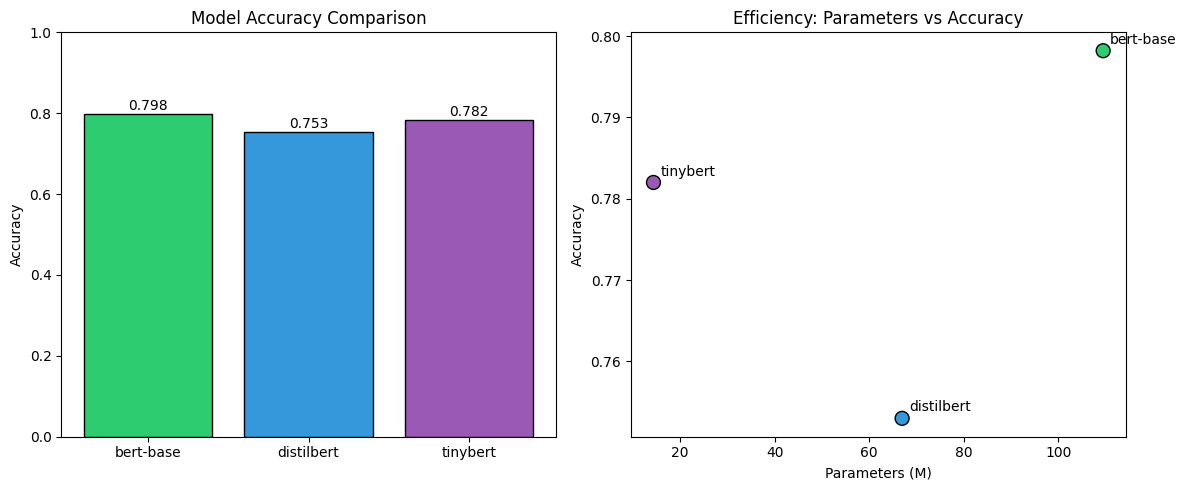

In [12]:
if results_data:
    import pandas as pd
    
    df = pd.DataFrame(results_data)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    colors = ['#2ecc71', '#3498db', '#9b59b6']
    axes[0].bar(df['Model'], df['Accuracy'], color=colors[:len(df)], edgecolor='black')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Model Accuracy Comparison')
    axes[0].set_ylim(0, 1)
    for i, v in enumerate(df['Accuracy']):
        axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center')
    
    axes[1].scatter(df['Parameters'] / 1e6, df['Accuracy'], s=100, c=colors[:len(df)], edgecolor='black')
    for i, row in df.iterrows():
        axes[1].annotate(row['Model'], (row['Parameters']/1e6, row['Accuracy']),
                        xytext=(5, 5), textcoords='offset points')
    axes[1].set_xlabel('Parameters (M)')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Efficiency: Parameters vs Accuracy')
    
    plt.tight_layout()
    plt.savefig(os.path.join(config.LOG_DIR, 'mnli_training_comparison.png'), dpi=150, bbox_inches='tight')
    plt.show()

In [13]:
all_results = {
    'dataset': 'MNLI',
    'task': 'Natural Language Inference',
    'train_samples': len(train_dataset),
    'eval_samples': len(eval_dataset),
    'config': {
        'batch_size': config.BATCH_SIZE,
        'learning_rate': config.LEARNING_RATE,
        'epochs': config.NUM_EPOCHS
    },
    'results': training_results
}

results_path = os.path.join(config.LOG_DIR, 'mnli_training_results.json')
with open(results_path, 'w') as f:
    json.dump(all_results, f, indent=2, default=float)

print(f"\n✅ Results saved to: {results_path}")


✅ Results saved to: ./logs/mnli_training_results.json
